In [1]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as  sns
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from yellowbrick.model_selection import LearningCurve
from sklearn.neural_network import MLPRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import re
from sklearn.preprocessing import LabelEncoder


#to plot in notebook
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Importation of the data

In [2]:
#Creating dataframe by loading the csv file
#This data consists of the daily sales betwee 01-10-2018 to 27-08-2019
df_sales = pd.DataFrame(pd.read_csv("Case3_Sales data.csv",sep=";"))
df_sales

,DATE,Mapped_GCK,Sales_EUR
0,01.10.2018,#1,0
1,02.10.2018,#1,0
2,03.10.2018,#1,0
3,04.10.2018,#1,0
4,05.10.2018,#1,0
...,...,...,...
9797,23.08.2019,#12,0
9798,23.08.2019,#36,1015
9799,12.08.2019,#12,0
9800,28.08.2019,#8,"43763,91"


In [3]:
#Creating dataframe by loading the excel file
#This data is composed various macroeconomic indexes that involve a few countries that includes Germany, and the World
df_market = pd.DataFrame(pd.read_excel("Case3_Market data.xlsx"))
df_market

,Unnamed: 0,China,China.1,France,France.1,Germany,Germany.1,Italy,Italy.1,Japan,...,production index.10,production index.11,production index.12,production index.13,production index.14,production index.15,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51
0,Index 2010=100 (if not otherwise noted),Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,...,Switzerland: Electrical equipment,United Kingdom: Electrical equipment,Italy: Electrical equipment,Japan: Electrical equipment,France: Electrical equipment,Germany: Electrical equipment,NaN,NaN,NaN,NaN
1,date,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_PRO250,MAB_ELE_SHP250,MAB_ELE_PRO276,MAB_ELE_SHP276,MAB_ELE_PRO380,MAB_ELE_SHP380,MAB_ELE_PRO392,...,PRO27756_org,PRO27826_org,PRO27380_org,PRO27392_org,PRO27250_org,PRO27276_org,NaN,NaN,NaN,NaN
2,2004m2,16.940704,16.940704,112.091273,83.458866,82.623037,79.452532,124.289603,86.560493,109.33401,...,81.1,120.706516,141.510864,106.161262,102.077057,85.9132,NaN,NaN,NaN,NaN
3,2004m3,23.711852,23.711852,136.327976,106.168192,100.556582,97.012918,143.411662,106.344544,140.884616,...,76.690307,138.30955,152.880234,140.288741,117.225685,97.670815,NaN,NaN,NaN,NaN
4,2004m4,24.435235,24.435235,117.791806,92.007646,89.653203,84.932358,129.083828,95.579673,105.853579,...,71.552403,115.55733,137.796875,106.271197,105.335777,87.253983,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,2021m12,310.763183,310.763183,100.565744,134.589504,118.103281,149.364286,94.006826,150.482735,127.771735,...,114.326241,121.065762,72.915611,109.005151,80.763306,97.773956,NaN,NaN,NaN,NaN
217,2022m1,235.956129,235.956129,85.743503,108.15632,94.55061,120.353403,86.851008,101.258277,110.460181,...,108.999212,112.324119,74.355736,95.369065,77.944954,98.599052,NaN,NaN,NaN,NaN
218,2022m2,235.956129,235.956129,90.60354,117.71577,103.987916,129.383676,106.583758,120.956538,117.879631,...,103.672183,115.55733,91.182419,103.950687,79.001831,106.128059,NaN,NaN,NaN,NaN
219,2022m3,329.413367,329.413367,107.843548,136.85872,121.308119,151.201314,124.637966,153.645142,152.000561,...,98.345154,145.254965,102.475998,133.743932,96.704582,119.948433,NaN,NaN,NaN,NaN


In [4]:
#Creating dataframe by loading the csv file
#This is the data in which we will submit our final predictions
df_test_data = pd.DataFrame(pd.read_csv("Case3_Test Set Template.csv",sep=";"))
df_test_data

,Month Year,Mapped_GCK,Sales_EUR
0,Mai 22,#3,NaN
1,Jun 22,#3,NaN
2,Jul 22,#3,NaN
3,Aug 22,#3,NaN
4,Sep 22,#3,NaN
...,...,...,...
135,Okt 22,#1,NaN
136,Nov 22,#1,NaN
137,Dez 22,#1,NaN
138,Jan 23,#1,NaN


The first issue we can observe from the 3 dataframes is the fact that all of them have different ways to present dates.

While df_sales has the format "01.10.2018", df_market has "2004m2", and df_test_data has "Mai 22".

We will start the code with fixing this issue.

In [5]:
#We start off with the dataframe df_market by diving it into two parts:
df_market_name = df_market.iloc[:2,:] #one that does not consider the dates
df_market_value = df_market.iloc[2:, :]#one that only considers the dates to change

In [6]:
#Here is the new dataframe without any dates nor numeric values
df_market_name

,Unnamed: 0,China,China.1,France,France.1,Germany,Germany.1,Italy,Italy.1,Japan,...,production index.10,production index.11,production index.12,production index.13,production index.14,production index.15,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51
0,Index 2010=100 (if not otherwise noted),Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,...,Switzerland: Electrical equipment,United Kingdom: Electrical equipment,Italy: Electrical equipment,Japan: Electrical equipment,France: Electrical equipment,Germany: Electrical equipment,NaN,NaN,NaN,NaN
1,date,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_PRO250,MAB_ELE_SHP250,MAB_ELE_PRO276,MAB_ELE_SHP276,MAB_ELE_PRO380,MAB_ELE_SHP380,MAB_ELE_PRO392,...,PRO27756_org,PRO27826_org,PRO27380_org,PRO27392_org,PRO27250_org,PRO27276_org,NaN,NaN,NaN,NaN


In [7]:
#The dataframe that has all the dates and numerica values
df_market_value

,Unnamed: 0,China,China.1,France,France.1,Germany,Germany.1,Italy,Italy.1,Japan,...,production index.10,production index.11,production index.12,production index.13,production index.14,production index.15,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51
2,2004m2,16.940704,16.940704,112.091273,83.458866,82.623037,79.452532,124.289603,86.560493,109.33401,...,81.1,120.706516,141.510864,106.161262,102.077057,85.9132,NaN,NaN,NaN,NaN
3,2004m3,23.711852,23.711852,136.327976,106.168192,100.556582,97.012918,143.411662,106.344544,140.884616,...,76.690307,138.30955,152.880234,140.288741,117.225685,97.670815,NaN,NaN,NaN,NaN
4,2004m4,24.435235,24.435235,117.791806,92.007646,89.653203,84.932358,129.083828,95.579673,105.853579,...,71.552403,115.55733,137.796875,106.271197,105.335777,87.253983,NaN,NaN,NaN,NaN
5,2004m5,23.708115,23.708115,109.002541,85.696486,86.880571,82.372794,135.590391,100.087039,101.864777,...,66.4145,119.269534,143.860535,101.60871,96.616508,84.675552,NaN,NaN,NaN,NaN
6,2004m6,27.009138,27.009138,133.785737,106.641482,99.010814,95.10874,136.424935,110.889719,120.33292,...,61.276596,128.849416,144.315308,116.655248,118.45871,95.401802,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,2021m12,310.763183,310.763183,100.565744,134.589504,118.103281,149.364286,94.006826,150.482735,127.771735,...,114.326241,121.065762,72.915611,109.005151,80.763306,97.773956,NaN,NaN,NaN,NaN
217,2022m1,235.956129,235.956129,85.743503,108.15632,94.55061,120.353403,86.851008,101.258277,110.460181,...,108.999212,112.324119,74.355736,95.369065,77.944954,98.599052,NaN,NaN,NaN,NaN
218,2022m2,235.956129,235.956129,90.60354,117.71577,103.987916,129.383676,106.583758,120.956538,117.879631,...,103.672183,115.55733,91.182419,103.950687,79.001831,106.128059,NaN,NaN,NaN,NaN
219,2022m3,329.413367,329.413367,107.843548,136.85872,121.308119,151.201314,124.637966,153.645142,152.000561,...,98.345154,145.254965,102.475998,133.743932,96.704582,119.948433,NaN,NaN,NaN,NaN


In [8]:
#Now we will grab df_market_value and change the dates by not only formating this way "YYYY-MM-DD"...
#but also turning these values from strings to datetime.date
#The original dataframe only had year and month on the values, we will just put all the days as "01"...
#...if this becomes a issue, it will be resolved further below

#Here is the function that will convert the values into datetime and also convert it to the format above indicated
def convert_time_months(time_str):
    datetime_obj = dt.datetime.strptime(time_str.strip(), '%Ym%m')
    return datetime_obj.date()

#Now we will apply the function above
df_market_value['Unnamed: 0'] = df_market_value['Unnamed: 0'].apply(convert_time_months) #creation of a new column from the original one wiht the function

#Here is the result
df_market_value

,Unnamed: 0,China,China.1,France,France.1,Germany,Germany.1,Italy,Italy.1,Japan,...,production index.10,production index.11,production index.12,production index.13,production index.14,production index.15,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51
2,2004-02-01,16.940704,16.940704,112.091273,83.458866,82.623037,79.452532,124.289603,86.560493,109.33401,...,81.1,120.706516,141.510864,106.161262,102.077057,85.9132,NaN,NaN,NaN,NaN
3,2004-03-01,23.711852,23.711852,136.327976,106.168192,100.556582,97.012918,143.411662,106.344544,140.884616,...,76.690307,138.30955,152.880234,140.288741,117.225685,97.670815,NaN,NaN,NaN,NaN
4,2004-04-01,24.435235,24.435235,117.791806,92.007646,89.653203,84.932358,129.083828,95.579673,105.853579,...,71.552403,115.55733,137.796875,106.271197,105.335777,87.253983,NaN,NaN,NaN,NaN
5,2004-05-01,23.708115,23.708115,109.002541,85.696486,86.880571,82.372794,135.590391,100.087039,101.864777,...,66.4145,119.269534,143.860535,101.60871,96.616508,84.675552,NaN,NaN,NaN,NaN
6,2004-06-01,27.009138,27.009138,133.785737,106.641482,99.010814,95.10874,136.424935,110.889719,120.33292,...,61.276596,128.849416,144.315308,116.655248,118.45871,95.401802,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,2021-12-01,310.763183,310.763183,100.565744,134.589504,118.103281,149.364286,94.006826,150.482735,127.771735,...,114.326241,121.065762,72.915611,109.005151,80.763306,97.773956,NaN,NaN,NaN,NaN
217,2022-01-01,235.956129,235.956129,85.743503,108.15632,94.55061,120.353403,86.851008,101.258277,110.460181,...,108.999212,112.324119,74.355736,95.369065,77.944954,98.599052,NaN,NaN,NaN,NaN
218,2022-02-01,235.956129,235.956129,90.60354,117.71577,103.987916,129.383676,106.583758,120.956538,117.879631,...,103.672183,115.55733,91.182419,103.950687,79.001831,106.128059,NaN,NaN,NaN,NaN
219,2022-03-01,329.413367,329.413367,107.843548,136.85872,121.308119,151.201314,124.637966,153.645142,152.000561,...,98.345154,145.254965,102.475998,133.743932,96.704582,119.948433,NaN,NaN,NaN,NaN


In [9]:
#Merging the two dataframes to create the original one with the alteration fo the date
df_market = pd.concat([df_market_name, df_market_value])

#Removing columns with nan values
df_market = df_market.dropna(axis=1, how='all')

#Making the column with the dates the index to not interfere with the algorithms that will be used...
#...the algorithms in question do not work with strings, only numeric values
df_market = df_market.set_index('Unnamed: 0')
df_market.index.name = 'Date' #Changing the name of the index

#Changing the index value of the row named "date" to "Abbreviaton" that better fits the values of the row
df_market.rename(index={'date': 'Abbreviation'}, inplace=True)

In [10]:
#This is how the dataframe looks like after the alterations
df_market

,China,China.1,France,France.1,Germany,Germany.1,Italy,Italy.1,Japan,Japan.1,...,production index.6,production index.7,production index.8,production index.9,production index.10,production index.11,production index.12,production index.13,production index.14,production index.15
Date,,,,,,,,,,,,,,,,,,,,,
Index 2010=100 (if not otherwise noted),Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,...,France: Machinery and equipment n.e.c.,Germany: Machinery and equipment n.e.c.,United States: Electrical equipment,World: Electrical equipment,Switzerland: Electrical equipment,United Kingdom: Electrical equipment,Italy: Electrical equipment,Japan: Electrical equipment,France: Electrical equipment,Germany: Electrical equipment
Abbreviation,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_PRO250,MAB_ELE_SHP250,MAB_ELE_PRO276,MAB_ELE_SHP276,MAB_ELE_PRO380,MAB_ELE_SHP380,MAB_ELE_PRO392,MAB_ELE_SHP392,...,PRO28250_org,PRO28276_org,PRO27840_org,PRO271000_org,PRO27756_org,PRO27826_org,PRO27380_org,PRO27392_org,PRO27250_org,PRO27276_org
2004-02-01,16.940704,16.940704,112.091273,83.458866,82.623037,79.452532,124.289603,86.560493,109.33401,110.495272,...,118.274109,80.82901,117.723991,NaN,81.1,120.706516,141.510864,106.161262,102.077057,85.9132
2004-03-01,23.711852,23.711852,136.327976,106.168192,100.556582,97.012918,143.411662,106.344544,140.884616,144.686166,...,148.121841,102.130104,119.220779,NaN,76.690307,138.30955,152.880234,140.288741,117.225685,97.670815
2004-04-01,24.435235,24.435235,117.791806,92.007646,89.653203,84.932358,129.083828,95.579673,105.853579,102.655769,...,125.482231,90.961426,117.441124,NaN,71.552403,115.55733,137.796875,106.271197,105.335777,87.253983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-01,310.763183,310.763183,100.565744,134.589504,118.103281,149.364286,94.006826,150.482735,127.771735,131.029703,...,112.791885,129.188248,109.624107,132.281006,114.326241,121.065762,72.915611,109.005151,80.763306,97.773956
2022-01-01,235.956129,235.956129,85.743503,108.15632,94.55061,120.353403,86.851008,101.258277,110.460181,110.823532,...,90.558372,92.343117,111.36467,122.236023,108.999212,112.324119,74.355736,95.369065,77.944954,98.599052
2022-02-01,235.956129,235.956129,90.60354,117.71577,103.987916,129.383676,106.583758,120.956538,117.879631,118.300232,...,97.766502,102.820961,114.6884,127.373421,103.672183,115.55733,91.182419,103.950687,79.001831,106.128059


In [11]:
#Now we will make the exact same process for the dataframe df_sales
#For this one we do not need to divide the dataframe and there are days in the original date

#We are creating a very similar function to the one above, but this one considers that the value entered as formated as "DD.MM.YYYY"
def convert_time_days(time_str):
    datetime_obj = dt.datetime.strptime(time_str.strip(), '%d.%m.%Y')
    return datetime_obj.date()

#Using the function to apply the changes as explained in the cells above
df_sales['DATE'] = df_sales['DATE'].apply(convert_time_days)
df_sales = df_sales.set_index('DATE')

#Changing the name of the index from "DATE" to "date" to be the same as df_market
df_market.rename(index={'DATE': 'Date'}, inplace=True)

In [12]:
#This is how the dataframe looks like after the alterations
df_sales

,Mapped_GCK,Sales_EUR
DATE,,
2018-10-01,#1,0
2018-10-02,#1,0
2018-10-03,#1,0
2018-10-04,#1,0
2018-10-05,#1,0
...,...,...
2019-08-23,#12,0
2019-08-23,#36,1015
2019-08-12,#12,0


In [13]:
#This code alters the first row that describes the data to add the value of the column, for example, "China", adds ": " and then it's original value
#The reason for this change is to remove the first row and make the column more redundant whilst keeping all the information
df_market.iloc[0] = df_market.columns.map(lambda col: col + ": " + str(df_market[col].iloc[0]))

In [14]:
df_market

,China,China.1,France,France.1,Germany,Germany.1,Italy,Italy.1,Japan,Japan.1,...,production index.6,production index.7,production index.8,production index.9,production index.10,production index.11,production index.12,production index.13,production index.14,production index.15
Date,,,,,,,,,,,,,,,,,,,,,
Index 2010=100 (if not otherwise noted),China: Production Index Machinery & Electricals,China.1: Shipments Index Machinery & Electricals,France: Production Index Machinery & Electricals,France.1: Shipments Index Machinery & Electricals,Germany: Production Index Machinery & Electricals,Germany.1: Shipments Index Machinery & Electri...,Italy: Production Index Machinery & Electricals,Italy.1: Shipments Index Machinery & Electricals,Japan: Production Index Machinery & Electricals,Japan.1: Shipments Index Machinery & Electricals,...,production index.6: France: Machinery and equi...,production index.7: Germany: Machinery and equ...,production index.8: United States: Electrical ...,production index.9: World: Electrical equipment,production index.10: Switzerland: Electrical e...,production index.11: United Kingdom: Electrica...,production index.12: Italy: Electrical equipment,production index.13: Japan: Electrical equipment,production index.14: France: Electrical equipment,production index.15: Germany: Electrical equip...
Abbreviation,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_PRO250,MAB_ELE_SHP250,MAB_ELE_PRO276,MAB_ELE_SHP276,MAB_ELE_PRO380,MAB_ELE_SHP380,MAB_ELE_PRO392,MAB_ELE_SHP392,...,PRO28250_org,PRO28276_org,PRO27840_org,PRO271000_org,PRO27756_org,PRO27826_org,PRO27380_org,PRO27392_org,PRO27250_org,PRO27276_org
2004-02-01,16.940704,16.940704,112.091273,83.458866,82.623037,79.452532,124.289603,86.560493,109.33401,110.495272,...,118.274109,80.82901,117.723991,NaN,81.1,120.706516,141.510864,106.161262,102.077057,85.9132
2004-03-01,23.711852,23.711852,136.327976,106.168192,100.556582,97.012918,143.411662,106.344544,140.884616,144.686166,...,148.121841,102.130104,119.220779,NaN,76.690307,138.30955,152.880234,140.288741,117.225685,97.670815
2004-04-01,24.435235,24.435235,117.791806,92.007646,89.653203,84.932358,129.083828,95.579673,105.853579,102.655769,...,125.482231,90.961426,117.441124,NaN,71.552403,115.55733,137.796875,106.271197,105.335777,87.253983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-01,310.763183,310.763183,100.565744,134.589504,118.103281,149.364286,94.006826,150.482735,127.771735,131.029703,...,112.791885,129.188248,109.624107,132.281006,114.326241,121.065762,72.915611,109.005151,80.763306,97.773956
2022-01-01,235.956129,235.956129,85.743503,108.15632,94.55061,120.353403,86.851008,101.258277,110.460181,110.823532,...,90.558372,92.343117,111.36467,122.236023,108.999212,112.324119,74.355736,95.369065,77.944954,98.599052
2022-02-01,235.956129,235.956129,90.60354,117.71577,103.987916,129.383676,106.583758,120.956538,117.879631,118.300232,...,97.766502,102.820961,114.6884,127.373421,103.672183,115.55733,91.182419,103.950687,79.001831,106.128059


Considering the output, whilst it does give all the information needed to interpret the data, it is not consistent.

For example, whilst the first column is "China: Production Index Machinery & Electricals" the penultimate is "production index.14: France: Electrical equipment".

We will change it to keep this format: "[country] [category] [sub-category]"

In [15]:
#This list was created considering the values in the dataframe and the format indicated above
first_row_replacement = ['China: Production Index Machinery & Electricals',
'China: Shipments Index Machinery & Electricals',
'France: Production Index Machinery & Electricals',
'France: Shipments Index Machinery & Electricals',
'Germany: Production Index Machinery & Electricals',
'Germany: Shipments Index Machinery & Electricals',
'Italy: Production Index Machinery & Electricals',
'Italy: Shipments Index Machinery & Electricals',
'Japan: Production Index Machinery & Electricals',
'Japan: Shipments Index Machinery & Electricals',
'Switzerland: Production Index Machinery & Electricals',
'Switzerland: Shipments Index Machinery & Electricals',
'United Kingdom: Production Index Machinery & Electricals',
'United Kingdom: Shipments Index Machinery & Electricals',
'United States: Production Index Machinery & Electricals',
'United States: Shipments Index Machinery & Electricals',
'Europe: Production Index Machinery & Electricals',
'Europe: Shipments Index Machinery & Electricals',
'World: Price of Base Metals',
'World: Price of Energy',
'World: Price of Metals & Minerals',
'World: Price of Natural Gas Index',
'World: Price of Crude Oil, Average',
'World: Price of Copper',
'United States: EUR in LCU',
'United States: Producer Prices Electrical Equipment',
'United Kingdom: Producer Prices Electrical Equipment',
'Italy: Producer Prices Electrical Equipment',
'France: Producer Prices Electrical Equipment',
'Germany: Producer Prices Electrical Equipment',
'China: Producer Prices Electrical Equipment',
'United States: Production Index Machinery and Equipment n.e.c.',
'World: Production Index Machinery and Equipment n.e.c.',
'Switzerland: Production Index Machinery and Equipment n.e.c.',
'United Kingdom: Production Index Machinery and Equipment n.e.c.',
'Italy: Production Index Machinery and Equipment n.e.c.',
'Japan: Production Index Machinery and Equipment n.e.c.',
'France: Production Index Machinery and Equipment n.e.c.',
'Germany: Production Index Machinery and Equipment n.e.c.',
'United States: Production Index Electrical Equipment',
'World: Production Index Electrical Equipment',
'Switzerland: Production Index Electrical Equipment',
'United Kingdom: Production Index Electrical Equipment',
'Italy: Production Index Electrical Equipment',
'Japan: Production Index Electrical Equipment',
'France: Production Index Electrical Equipment',
'Germany: Production Index Electrical Equipment']

#Now we will replace the first row's values with this new list to make it easier to interpret and read
df_market.loc["Index 2010=100 (if not otherwise noted)"] = first_row_replacement

#We will replace the column values with this first row that has both the values...
df_market.columns = df_market.iloc[0]
#...and drop the first row (which is now the column names)
df_market = df_market.drop(df_market.index[0])

In [16]:
df_market

Index 2010=100 (if not otherwise noted),China: Production Index Machinery & Electricals,China: Shipments Index Machinery & Electricals,France: Production Index Machinery & Electricals,France: Shipments Index Machinery & Electricals,Germany: Production Index Machinery & Electricals,Germany: Shipments Index Machinery & Electricals,Italy: Production Index Machinery & Electricals,Italy: Shipments Index Machinery & Electricals,Japan: Production Index Machinery & Electricals,Japan: Shipments Index Machinery & Electricals,...,France: Production Index Machinery and Equipment n.e.c.,Germany: Production Index Machinery and Equipment n.e.c.,United States: Production Index Electrical Equipment,World: Production Index Electrical Equipment,Switzerland: Production Index Electrical Equipment,United Kingdom: Production Index Electrical Equipment,Italy: Production Index Electrical Equipment,Japan: Production Index Electrical Equipment,France: Production Index Electrical Equipment,Germany: Production Index Electrical Equipment
Date,,,,,,,,,,,,,,,,,,,,,
Abbreviation,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_PRO250,MAB_ELE_SHP250,MAB_ELE_PRO276,MAB_ELE_SHP276,MAB_ELE_PRO380,MAB_ELE_SHP380,MAB_ELE_PRO392,MAB_ELE_SHP392,...,PRO28250_org,PRO28276_org,PRO27840_org,PRO271000_org,PRO27756_org,PRO27826_org,PRO27380_org,PRO27392_org,PRO27250_org,PRO27276_org
2004-02-01,16.940704,16.940704,112.091273,83.458866,82.623037,79.452532,124.289603,86.560493,109.33401,110.495272,...,118.274109,80.82901,117.723991,NaN,81.1,120.706516,141.510864,106.161262,102.077057,85.9132
2004-03-01,23.711852,23.711852,136.327976,106.168192,100.556582,97.012918,143.411662,106.344544,140.884616,144.686166,...,148.121841,102.130104,119.220779,NaN,76.690307,138.30955,152.880234,140.288741,117.225685,97.670815
2004-04-01,24.435235,24.435235,117.791806,92.007646,89.653203,84.932358,129.083828,95.579673,105.853579,102.655769,...,125.482231,90.961426,117.441124,NaN,71.552403,115.55733,137.796875,106.271197,105.335777,87.253983
2004-05-01,23.708115,23.708115,109.002541,85.696486,86.880571,82.372794,135.590391,100.087039,101.864777,100.305285,...,116.64975,88.082901,117.899216,NaN,66.4145,119.269534,143.860535,101.60871,96.616508,84.675552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-01,310.763183,310.763183,100.565744,134.589504,118.103281,149.364286,94.006826,150.482735,127.771735,131.029703,...,112.791885,129.188248,109.624107,132.281006,114.326241,121.065762,72.915611,109.005151,80.763306,97.773956
2022-01-01,235.956129,235.956129,85.743503,108.15632,94.55061,120.353403,86.851008,101.258277,110.460181,110.823532,...,90.558372,92.343117,111.36467,122.236023,108.999212,112.324119,74.355736,95.369065,77.944954,98.599052
2022-02-01,235.956129,235.956129,90.60354,117.71577,103.987916,129.383676,106.583758,120.956538,117.879631,118.300232,...,97.766502,102.820961,114.6884,127.373421,103.672183,115.55733,91.182419,103.950687,79.001831,106.128059


The restructuring of the dataframe df_market is almost complete. There is a few issues that will be addressed now that we can take away from the output above.

The first issue is the fact that whilst we did all possible to remove redundant parts, we still have the row with the index "Abbreviation" that do not represent numerica values. This will make the algorithim unable to analyse the data. So we will remove this row and, if needed in the future, add it back

Another possible is issue is that the indexes that indicate the date also appear to show the the hours, we will also remove these whilst keeping them as datetime.

In [17]:
#First we will convert the first row to save it if needed further below
abbreviations = df_market.loc["Abbreviation"]

#Second, we remove it from the dataframe
df_market = df_market.drop(index='Abbreviation')

#Third, we now remove the hours from the index of the dataframe
df_market.index = pd.to_datetime(df_market.index).date
#We will do the same for df_sales just in case it suffers the same problem
df_sales.index = pd.to_datetime(df_sales.index).date

In [18]:
df_market

Index 2010=100 (if not otherwise noted),China: Production Index Machinery & Electricals,China: Shipments Index Machinery & Electricals,France: Production Index Machinery & Electricals,France: Shipments Index Machinery & Electricals,Germany: Production Index Machinery & Electricals,Germany: Shipments Index Machinery & Electricals,Italy: Production Index Machinery & Electricals,Italy: Shipments Index Machinery & Electricals,Japan: Production Index Machinery & Electricals,Japan: Shipments Index Machinery & Electricals,...,France: Production Index Machinery and Equipment n.e.c.,Germany: Production Index Machinery and Equipment n.e.c.,United States: Production Index Electrical Equipment,World: Production Index Electrical Equipment,Switzerland: Production Index Electrical Equipment,United Kingdom: Production Index Electrical Equipment,Italy: Production Index Electrical Equipment,Japan: Production Index Electrical Equipment,France: Production Index Electrical Equipment,Germany: Production Index Electrical Equipment
2004-02-01,16.940704,16.940704,112.091273,83.458866,82.623037,79.452532,124.289603,86.560493,109.33401,110.495272,...,118.274109,80.82901,117.723991,NaN,81.1,120.706516,141.510864,106.161262,102.077057,85.9132
2004-03-01,23.711852,23.711852,136.327976,106.168192,100.556582,97.012918,143.411662,106.344544,140.884616,144.686166,...,148.121841,102.130104,119.220779,NaN,76.690307,138.30955,152.880234,140.288741,117.225685,97.670815
2004-04-01,24.435235,24.435235,117.791806,92.007646,89.653203,84.932358,129.083828,95.579673,105.853579,102.655769,...,125.482231,90.961426,117.441124,NaN,71.552403,115.55733,137.796875,106.271197,105.335777,87.253983
2004-05-01,23.708115,23.708115,109.002541,85.696486,86.880571,82.372794,135.590391,100.087039,101.864777,100.305285,...,116.64975,88.082901,117.899216,NaN,66.4145,119.269534,143.860535,101.60871,96.616508,84.675552
2004-06-01,27.009138,27.009138,133.785737,106.641482,99.010814,95.10874,136.424935,110.889719,120.33292,119.61638,...,143.248734,100.978699,119.499107,NaN,61.276596,128.849416,144.315308,116.655248,118.45871,95.401802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-01,310.763183,310.763183,100.565744,134.589504,118.103281,149.364286,94.006826,150.482735,127.771735,131.029703,...,112.791885,129.188248,109.624107,132.281006,114.326241,121.065762,72.915611,109.005151,80.763306,97.773956
2022-01-01,235.956129,235.956129,85.743503,108.15632,94.55061,120.353403,86.851008,101.258277,110.460181,110.823532,...,90.558372,92.343117,111.36467,122.236023,108.999212,112.324119,74.355736,95.369065,77.944954,98.599052
2022-02-01,235.956129,235.956129,90.60354,117.71577,103.987916,129.383676,106.583758,120.956538,117.879631,118.300232,...,97.766502,102.820961,114.6884,127.373421,103.672183,115.55733,91.182419,103.950687,79.001831,106.128059
2022-03-01,329.413367,329.413367,107.843548,136.85872,121.308119,151.201314,124.637966,153.645142,152.000561,156.400634,...,114.72081,122.049515,115.164093,152.452942,98.345154,145.254965,102.475998,133.743932,96.704582,119.948433


The df_market, in terms of strucutre, is finished. Now we must merge df_sales with it.

The biggest issue that has to do with index. Whilst df_sales' index shows the specific day of the sale, df_market only has data related to month and all the days are set to "01".

To resolve this issue, we will group the index and column Mapped_GCK of df_sales whilst summing them to both dataframes to be in months.

In [19]:
df_sales

,Mapped_GCK,Sales_EUR
2018-10-01,#1,0
2018-10-02,#1,0
2018-10-03,#1,0
2018-10-04,#1,0
2018-10-05,#1,0
...,...,...
2019-08-23,#12,0
2019-08-23,#36,1015
2019-08-12,#12,0
2019-08-28,#8,"43763,91"


In [20]:
#First, we will sum the values of the sales, grouping by their type, and the the year and month...
#...after this we will merge both the dataframes

#To sum the different values of the sales, we must turn the values into floats, right now they are strings and have...
#...commas instead of points
df_sales.Sales_EUR = df_sales.Sales_EUR.str.replace(",",".").astype(float)

#We will turn the index into datetime to be able to group by month
df_sales.index = pd.to_datetime(df_sales.index)
#Grouping by month and also type of product
monthly_sales = df_sales.groupby([pd.Grouper(freq='M'), 'Mapped_GCK']).sum()

#Now we reset the index to be able to remove the day of the date
monthly_sales = monthly_sales.reset_index()
#Removing the days from the new formed column
monthly_sales['Date'] = monthly_sales['level_0'].dt.to_period('M')
#Setting it back the date to be the index
monthly_sales = monthly_sales.set_index(['Date'])
#Dropping the column that we just created
monthly_sales = monthly_sales.drop('level_0', axis=1)
#Converting the dataframe created to be the new df_sales
df_sales = monthly_sales

In [21]:
df_sales

,Mapped_GCK,Sales_EUR
Date,,
2018-10,#1,36098918.79
2018-10,#11,1021303.50
2018-10,#12,28686.33
2018-10,#13,27666.10
2018-10,#14,5770.00
...,...,...
2022-04,#4,302057.04
2022-04,#5,8884607.53
2022-04,#6,333705.61


The dataframe, df_sales, looks ready to merge with df_market.

In [22]:
df_sales

,Mapped_GCK,Sales_EUR
Date,,
2018-10,#1,36098918.79
2018-10,#11,1021303.50
2018-10,#12,28686.33
2018-10,#13,27666.10
2018-10,#14,5770.00
...,...,...
2022-04,#4,302057.04
2022-04,#5,8884607.53
2022-04,#6,333705.61


In [23]:
#Now we will rewrite the code to adjust to the dataframe df_market

#We will turn the index into datetime to be able to group by month
df_market.index = pd.to_datetime(df_market.index)

#Now we reset the index to be able to remove the day of the date
monthly_sales = df_market.reset_index()
#Removing the days from the new formed column
monthly_sales['Date'] = monthly_sales['index'].dt.to_period('M')
#Setting it back the date to be the index
monthly_sales = monthly_sales.set_index(['Date'])
#Dropping the column that we just created
monthly_sales = monthly_sales.drop('index', axis=1)
#Converting the dataframe created to be the new df_market
df_market = monthly_sales

In [24]:
df_market

Index 2010=100 (if not otherwise noted),China: Production Index Machinery & Electricals,China: Shipments Index Machinery & Electricals,France: Production Index Machinery & Electricals,France: Shipments Index Machinery & Electricals,Germany: Production Index Machinery & Electricals,Germany: Shipments Index Machinery & Electricals,Italy: Production Index Machinery & Electricals,Italy: Shipments Index Machinery & Electricals,Japan: Production Index Machinery & Electricals,Japan: Shipments Index Machinery & Electricals,...,France: Production Index Machinery and Equipment n.e.c.,Germany: Production Index Machinery and Equipment n.e.c.,United States: Production Index Electrical Equipment,World: Production Index Electrical Equipment,Switzerland: Production Index Electrical Equipment,United Kingdom: Production Index Electrical Equipment,Italy: Production Index Electrical Equipment,Japan: Production Index Electrical Equipment,France: Production Index Electrical Equipment,Germany: Production Index Electrical Equipment
Date,,,,,,,,,,,,,,,,,,,,,
2004-02,16.940704,16.940704,112.091273,83.458866,82.623037,79.452532,124.289603,86.560493,109.33401,110.495272,...,118.274109,80.82901,117.723991,NaN,81.1,120.706516,141.510864,106.161262,102.077057,85.9132
2004-03,23.711852,23.711852,136.327976,106.168192,100.556582,97.012918,143.411662,106.344544,140.884616,144.686166,...,148.121841,102.130104,119.220779,NaN,76.690307,138.30955,152.880234,140.288741,117.225685,97.670815
2004-04,24.435235,24.435235,117.791806,92.007646,89.653203,84.932358,129.083828,95.579673,105.853579,102.655769,...,125.482231,90.961426,117.441124,NaN,71.552403,115.55733,137.796875,106.271197,105.335777,87.253983
2004-05,23.708115,23.708115,109.002541,85.696486,86.880571,82.372794,135.590391,100.087039,101.864777,100.305285,...,116.64975,88.082901,117.899216,NaN,66.4145,119.269534,143.860535,101.60871,96.616508,84.675552
2004-06,27.009138,27.009138,133.785737,106.641482,99.010814,95.10874,136.424935,110.889719,120.33292,119.61638,...,143.248734,100.978699,119.499107,NaN,61.276596,128.849416,144.315308,116.655248,118.45871,95.401802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12,310.763183,310.763183,100.565744,134.589504,118.103281,149.364286,94.006826,150.482735,127.771735,131.029703,...,112.791885,129.188248,109.624107,132.281006,114.326241,121.065762,72.915611,109.005151,80.763306,97.773956
2022-01,235.956129,235.956129,85.743503,108.15632,94.55061,120.353403,86.851008,101.258277,110.460181,110.823532,...,90.558372,92.343117,111.36467,122.236023,108.999212,112.324119,74.355736,95.369065,77.944954,98.599052
2022-02,235.956129,235.956129,90.60354,117.71577,103.987916,129.383676,106.583758,120.956538,117.879631,118.300232,...,97.766502,102.820961,114.6884,127.373421,103.672183,115.55733,91.182419,103.950687,79.001831,106.128059


Now that both dataframes have the same index, we can now merge them together to create our final dataframe

In [25]:
df = pd.merge(df_sales, df_market, on='Date', how="inner")
df

,Mapped_GCK,Sales_EUR,China: Production Index Machinery & Electricals,China: Shipments Index Machinery & Electricals,France: Production Index Machinery & Electricals,France: Shipments Index Machinery & Electricals,Germany: Production Index Machinery & Electricals,Germany: Shipments Index Machinery & Electricals,Italy: Production Index Machinery & Electricals,Italy: Shipments Index Machinery & Electricals,...,France: Production Index Machinery and Equipment n.e.c.,Germany: Production Index Machinery and Equipment n.e.c.,United States: Production Index Electrical Equipment,World: Production Index Electrical Equipment,Switzerland: Production Index Electrical Equipment,United Kingdom: Production Index Electrical Equipment,Italy: Production Index Electrical Equipment,Japan: Production Index Electrical Equipment,France: Production Index Electrical Equipment,Germany: Production Index Electrical Equipment
Date,,,,,,,,,,,,,,,,,,,,,
2018-10,#1,36098918.79,211.955755,211.955755,108.280608,122.451734,124.227879,137.741953,118.350514,122.456894,...,114.72081,127.461136,112.853256,129.325775,112.970843,118.670791,93.001511,112.376774,97.849541,118.298233
2018-10,#11,1021303.50,211.955755,211.955755,108.280608,122.451734,124.227879,137.741953,118.350514,122.456894,...,114.72081,127.461136,112.853256,129.325775,112.970843,118.670791,93.001511,112.376774,97.849541,118.298233
2018-10,#12,28686.33,211.955755,211.955755,108.280608,122.451734,124.227879,137.741953,118.350514,122.456894,...,114.72081,127.461136,112.853256,129.325775,112.970843,118.670791,93.001511,112.376774,97.849541,118.298233
2018-10,#13,27666.10,211.955755,211.955755,108.280608,122.451734,124.227879,137.741953,118.350514,122.456894,...,114.72081,127.461136,112.853256,129.325775,112.970843,118.670791,93.001511,112.376774,97.849541,118.298233
2018-10,#14,5770.00,211.955755,211.955755,108.280608,122.451734,124.227879,137.741953,118.350514,122.456894,...,114.72081,127.461136,112.853256,129.325775,112.970843,118.670791,93.001511,112.376774,97.849541,118.298233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04,#4,302057.04,267.373145,267.373145,87.69811,116.528738,99.522205,127.022869,103.55669,128.733305,...,91.979698,98.675873,112.158089,134.843353,NaN,114.359844,86.255684,102.36168,80.763306,101.074341
2022-04,#5,8884607.53,267.373145,267.373145,87.69811,116.528738,99.522205,127.022869,103.55669,128.733305,...,91.979698,98.675873,112.158089,134.843353,NaN,114.359844,86.255684,102.36168,80.763306,101.074341
2022-04,#6,333705.61,267.373145,267.373145,87.69811,116.528738,99.522205,127.022869,103.55669,128.733305,...,91.979698,98.675873,112.158089,134.843353,NaN,114.359844,86.255684,102.36168,80.763306,101.074341


# 1 - Exploration

## 1.1. - Data Analysis

Now that the dataframes are combined and ready to be used, we will explore it to better understand it and fix any issues.

In [26]:
#We will start by checking how many rows and columns our dataframe has
df.shape

(602, 49)

In [27]:
#Now we will verify what data types our columns are adn check for any missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 602 entries, 2018-10 to 2022-04
Freq: M
Data columns (total 49 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   Mapped_GCK                                                       602 non-null    object 
 1   Sales_EUR                                                        602 non-null    float64
 2   China: Production Index Machinery & Electricals                  602 non-null    object 
 3   China: Shipments Index Machinery & Electricals                   602 non-null    object 
 4   France: Production Index Machinery & Electricals                 602 non-null    object 
 5   France: Shipments Index Machinery & Electricals                  602 non-null    object 
 6   Germany: Production Index Machinery & Electricals                602 non-null    object 
 7   Germany: Shipments Index 

As we can verify above, the only issue derives from the data from df_market.

All are objects and some have missing values.

To fix this problem we will first conver them to float and fill the missing values with knn.

The reason for the use of knn derives from the fact that we are looking at a time series. Any other simpler method would consider all the data, independently of date, to be as important as the closest dates.

In [28]:
#We start by creating a list to indicate which columns we want to change
#In this case it's just the columns of df_market
cols_to_convert = df_market.columns.tolist()
#We convert said columns to floats
df[cols_to_convert] = df[cols_to_convert].astype(float)

#Then we start using knn
#Although knn only considers data within the column to replace the empty values...
#...the algorithim itself does not allow to any column that isn't numeric to be within the dataframe...
#...so, to make it easier, we will jus remove Mapped_GCK and put it back in the end
product_group = df.Mapped_GCK
df = df.drop('Mapped_GCK', axis=1)
#Imputting the missing values of the dataframe while using the 5 nearest neighboors
imputer = KNNImputer(n_neighbors=5)
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)
#Adding back Mapped_GCK
df['Mapped_GCK'] = product_group

In [29]:
df.describe()

,Sales_EUR,China: Production Index Machinery & Electricals,China: Shipments Index Machinery & Electricals,France: Production Index Machinery & Electricals,France: Shipments Index Machinery & Electricals,Germany: Production Index Machinery & Electricals,Germany: Shipments Index Machinery & Electricals,Italy: Production Index Machinery & Electricals,Italy: Shipments Index Machinery & Electricals,Japan: Production Index Machinery & Electricals,...,France: Production Index Machinery and Equipment n.e.c.,Germany: Production Index Machinery and Equipment n.e.c.,United States: Production Index Electrical Equipment,World: Production Index Electrical Equipment,Switzerland: Production Index Electrical Equipment,United Kingdom: Production Index Electrical Equipment,Italy: Production Index Electrical Equipment,Japan: Production Index Electrical Equipment,France: Production Index Electrical Equipment,Germany: Production Index Electrical Equipment
count,6.020000e+02,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,...,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000
mean,4.441603e+06,245.869125,245.869125,91.481515,110.751518,108.687039,127.618849,99.325236,114.273597,113.788503,...,97.785387,111.925134,108.737324,125.996910,101.534837,118.400661,80.861839,104.927961,81.271259,102.748522
std,9.743326e+06,42.900514,42.900514,13.082689,14.578215,10.485777,12.994500,17.569811,20.999362,14.022688,...,14.799617,13.212788,4.239585,11.021707,9.740667,11.743439,15.370304,12.258193,10.894994,9.360653
min,-1.520296e+04,130.439177,130.439177,50.756680,64.420676,81.061581,93.292777,50.618181,55.137229,82.022903,...,54.416245,81.059303,97.650742,103.481438,77.541371,77.956292,38.959072,78.573698,44.829357,81.065758
25%,1.376013e+04,219.595813,219.595813,87.698110,103.635875,102.878699,120.353403,89.617695,101.258277,104.249772,...,92.994919,102.820961,107.644180,119.102165,93.018125,112.922862,74.355736,97.662200,77.944954,97.773956
50%,2.911754e+05,244.074699,244.074699,94.067274,114.917432,109.597012,128.931038,103.660830,120.110839,114.030178,...,100.304573,112.838226,109.499725,126.429832,102.852640,117.832552,85.042946,103.440134,81.996330,104.684143
75%,1.591996e+06,269.794432,269.794432,99.731150,119.047516,115.951560,137.741953,111.887888,128.733305,122.624695,...,106.091377,122.279793,111.364670,133.984802,110.354610,126.214949,91.637192,111.907535,88.777977,107.778252
max,4.448301e+07,329.413367,329.413367,109.451042,136.858720,127.404132,151.201314,124.637966,153.645142,152.000561,...,118.680206,137.363281,115.164093,152.452942,116.501182,145.254965,102.475998,134.592862,97.849541,119.948433


The only part of the output that could be considered to be incoherent is the fact that sales have negative values. But this can be explained with the devolution and creation of credit to the customers in question.

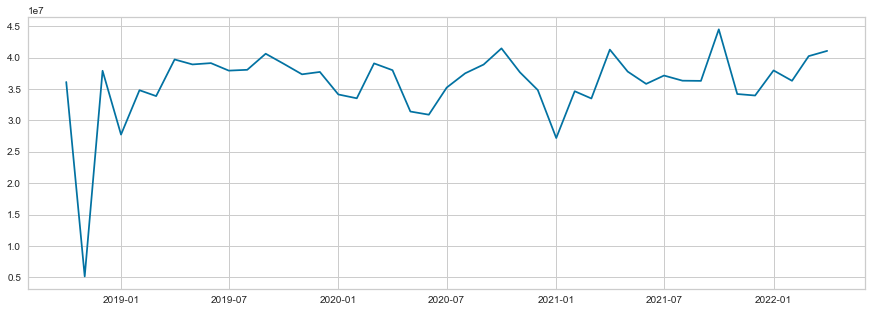

In [31]:
# convert the 'Date' index from Period to datetime
df.index = df.index.to_timestamp()

filtered_df = df[df['Mapped_GCK'] == '#1']

# plot the 'Sales_EUR' column
plt.figure(figsize=(15,5))
plt.plot(filtered_df['Sales_EUR'])
plt.show()


## DELETE THIS
One advantage of additive decomposition is that it can be easier to interpret the individual components since they are added together to create the original time-series. Additionally, additive decomposition tends to work well for time-series data where the magnitude of the seasonal variation is roughly constant over time.

On the other hand, one advantage of multiplicative decomposition is that it can be more appropriate for time-series data where the seasonal variation is proportional to the level of the time-series. This can often be the case with economic or financial data, where the seasonal variation increases with the overall level of economic activity.

In [32]:
df[df['Mapped_GCK'] == '#1']

,Sales_EUR,China: Production Index Machinery & Electricals,China: Shipments Index Machinery & Electricals,France: Production Index Machinery & Electricals,France: Shipments Index Machinery & Electricals,Germany: Production Index Machinery & Electricals,Germany: Shipments Index Machinery & Electricals,Italy: Production Index Machinery & Electricals,Italy: Shipments Index Machinery & Electricals,Japan: Production Index Machinery & Electricals,...,Germany: Production Index Machinery and Equipment n.e.c.,United States: Production Index Electrical Equipment,World: Production Index Electrical Equipment,Switzerland: Production Index Electrical Equipment,United Kingdom: Production Index Electrical Equipment,Italy: Production Index Electrical Equipment,Japan: Production Index Electrical Equipment,France: Production Index Electrical Equipment,Germany: Production Index Electrical Equipment,Mapped_GCK
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-01,36098918.79,211.955755,211.955755,108.280608,122.451734,124.227879,137.741953,118.350514,122.456894,125.209957,...,127.461136,112.853256,129.325775,112.970843,118.670791,93.001511,112.376774,97.849541,118.298233,#1
2018-11-01,5140760.00,220.519655,220.519655,99.636911,115.958210,127.404132,142.732193,107.719260,120.132032,122.624695,...,132.987915,113.145294,128.236176,114.736013,120.467019,84.133400,111.907535,91.155960,117.163727,#1
2018-12-01,37889612.12,241.846854,241.846854,94.690312,115.128469,120.518565,141.407661,88.783181,131.936099,122.991956,...,137.363281,111.823624,117.043549,116.501182,105.378705,64.881248,112.524242,78.033028,89.626122,#1
2019-01-01,27728148.35,175.668147,175.668147,90.143775,108.325154,104.776326,118.703828,99.275113,92.418842,105.514024,...,104.432930,109.499725,111.522202,110.354610,107.174933,81.556343,95.957352,81.908257,105.406097,#1
2019-02-01,34793163.53,175.668147,175.668147,92.551521,108.944656,109.597012,122.686997,104.586684,103.214212,114.466647,...,112.838226,110.835655,112.666725,104.208038,110.647640,83.451233,107.309956,80.322929,103.652771,#1
2019-03-01,33856803.04,261.642802,261.642802,107.861788,126.966216,122.534648,140.116214,114.299549,122.454318,141.637717,...,128.612549,111.092499,131.456177,98.061466,126.214949,88.832741,131.450762,92.477066,111.388054,#1
2019-04-01,39688292.01,219.595813,219.595813,98.677844,114.917432,110.612414,127.512006,99.732969,106.279804,107.150653,...,115.025909,109.490013,119.415619,95.539795,113.521605,75.947449,101.308407,85.519257,102.518265,#1
2019-05-01,38897974.29,234.169196,234.169196,94.779550,110.814496,115.712333,131.993634,118.006286,123.261639,108.940926,...,120.207260,111.786377,122.786171,93.018125,117.593055,91.637192,101.892947,84.022011,107.468842,#1
2019-06-01,39106750.23,261.126350,261.126350,98.978105,122.045555,108.917455,126.769557,108.231888,121.312004,117.747574,...,116.062180,112.188866,125.168800,90.496454,123.101487,83.527031,112.251279,87.456879,95.814354,#1


## Have different views of the data

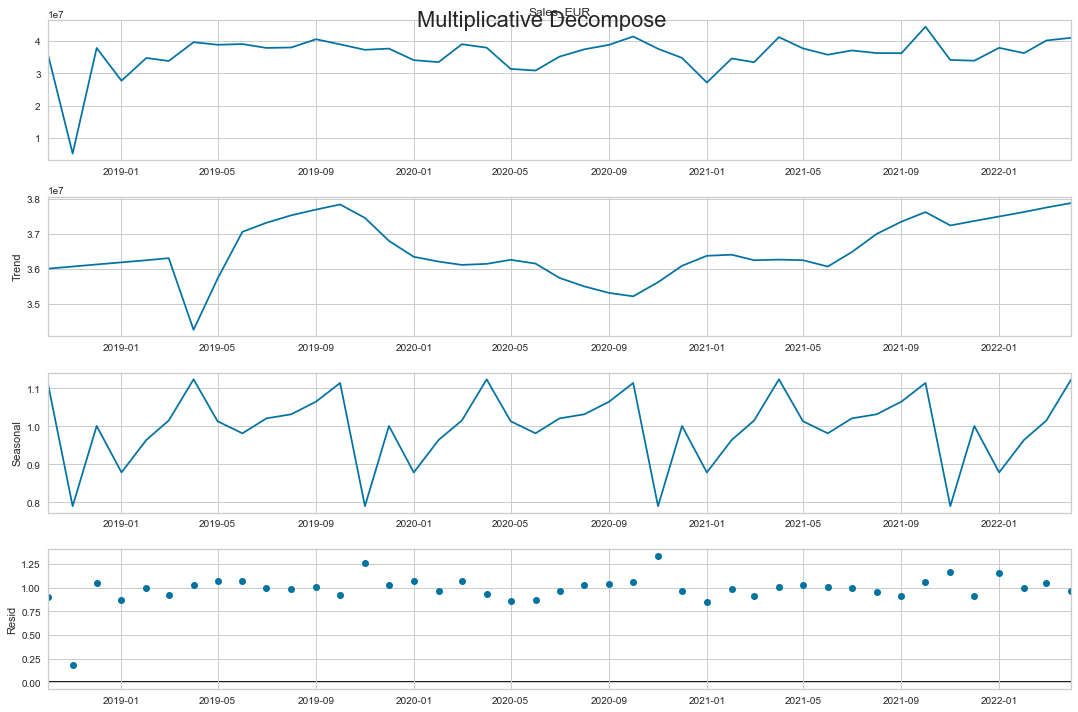

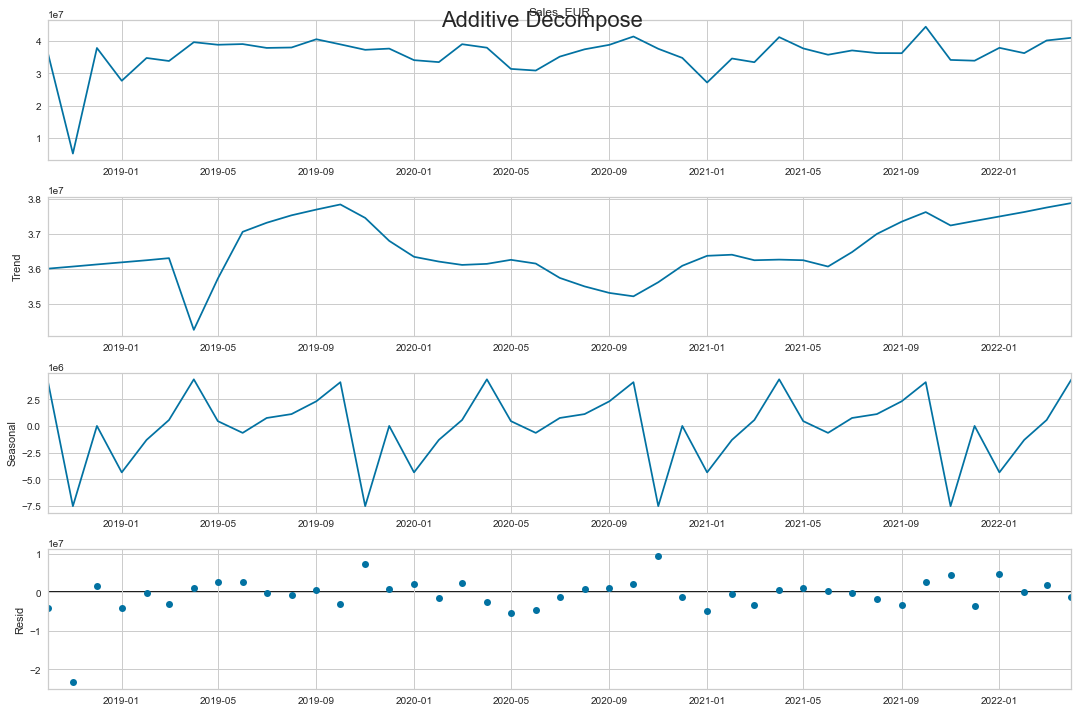

In [33]:
# Set period and extrapolate trend
period = 12
extrapolate_trend = 'freq'

# Multiplicative decomposition
result_mul = seasonal_decompose(df[df['Mapped_GCK'] == '#1'].Sales_EUR, model='multiplicative', period=period, extrapolate_trend=extrapolate_trend)

# Additive decomposition
result_add = seasonal_decompose(df[df['Mapped_GCK'] == '#1'].Sales_EUR, model='additive', period=period, extrapolate_trend=extrapolate_trend)

# Plot the results
plt.rcParams.update({'figure.figsize': (15,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()


## Data preparation

In [34]:
#ONLY HAS SALES VALUES
gck1 = df.loc[df['Mapped_GCK'] == '#1', ['Sales_EUR']]

In [35]:
# Function to create lag features
# Adapted from https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True, varNames=None):
    """"
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
        varNames: List of column names (same size as the number of variables).
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(varNames[j]+'(t-%d)' % (i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(varNames[j]+'(t)' ) for j in range(n_vars)]
        else:
            names += [(varNames[j]+'(t+%d)' % (i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [36]:
df

,Sales_EUR,China: Production Index Machinery & Electricals,China: Shipments Index Machinery & Electricals,France: Production Index Machinery & Electricals,France: Shipments Index Machinery & Electricals,Germany: Production Index Machinery & Electricals,Germany: Shipments Index Machinery & Electricals,Italy: Production Index Machinery & Electricals,Italy: Shipments Index Machinery & Electricals,Japan: Production Index Machinery & Electricals,...,Germany: Production Index Machinery and Equipment n.e.c.,United States: Production Index Electrical Equipment,World: Production Index Electrical Equipment,Switzerland: Production Index Electrical Equipment,United Kingdom: Production Index Electrical Equipment,Italy: Production Index Electrical Equipment,Japan: Production Index Electrical Equipment,France: Production Index Electrical Equipment,Germany: Production Index Electrical Equipment,Mapped_GCK
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-01,36098918.79,211.955755,211.955755,108.280608,122.451734,124.227879,137.741953,118.350514,122.456894,125.209957,...,127.461136,112.853256,129.325775,112.970843,118.670791,93.001511,112.376774,97.849541,118.298233,#1
2018-10-01,1021303.50,211.955755,211.955755,108.280608,122.451734,124.227879,137.741953,118.350514,122.456894,125.209957,...,127.461136,112.853256,129.325775,112.970843,118.670791,93.001511,112.376774,97.849541,118.298233,#11
2018-10-01,28686.33,211.955755,211.955755,108.280608,122.451734,124.227879,137.741953,118.350514,122.456894,125.209957,...,127.461136,112.853256,129.325775,112.970843,118.670791,93.001511,112.376774,97.849541,118.298233,#12
2018-10-01,27666.10,211.955755,211.955755,108.280608,122.451734,124.227879,137.741953,118.350514,122.456894,125.209957,...,127.461136,112.853256,129.325775,112.970843,118.670791,93.001511,112.376774,97.849541,118.298233,#13
2018-10-01,5770.00,211.955755,211.955755,108.280608,122.451734,124.227879,137.741953,118.350514,122.456894,125.209957,...,127.461136,112.853256,129.325775,112.970843,118.670791,93.001511,112.376774,97.849541,118.298233,#14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,302057.04,267.373145,267.373145,87.698110,116.528738,99.522205,127.022869,103.556690,128.733305,114.262328,...,98.675873,112.158089,134.843353,101.497242,114.359844,86.255684,102.361680,80.763306,101.074341,#4
2022-04-01,8884607.53,267.373145,267.373145,87.698110,116.528738,99.522205,127.022869,103.556690,128.733305,114.262328,...,98.675873,112.158089,134.843353,109.232467,114.359844,86.255684,102.361680,80.763306,101.074341,#5
2022-04-01,333705.61,267.373145,267.373145,87.698110,116.528738,99.522205,127.022869,103.556690,128.733305,114.262328,...,98.675873,112.158089,134.843353,102.405043,114.359844,86.255684,102.361680,80.763306,101.074341,#6


In [37]:
# Create lag features
lagDays = 10
X = series_to_supervised(gck1.values, lagDays, 1, varNames=gck1.columns.values.tolist())
X.set_index(gck1.index[lagDays:], inplace=True)
X

,Sales_EUR(t-10),Sales_EUR(t-9),Sales_EUR(t-8),Sales_EUR(t-7),Sales_EUR(t-6),Sales_EUR(t-5),Sales_EUR(t-4),Sales_EUR(t-3),Sales_EUR(t-2),Sales_EUR(t-1),Sales_EUR(t)
Date,,,,,,,,,,,
2019-08-01,36098918.79,5140760.00,37889612.12,27728148.35,34793163.53,33856803.04,39688292.01,38897974.29,39106750.23,37912572.30,38042677.05
2019-09-01,5140760.00,37889612.12,27728148.35,34793163.53,33856803.04,39688292.01,38897974.29,39106750.23,37912572.30,38042677.05,40602780.64
2019-10-01,37889612.12,27728148.35,34793163.53,33856803.04,39688292.01,38897974.29,39106750.23,37912572.30,38042677.05,40602780.64,39012299.19
2019-11-01,27728148.35,34793163.53,33856803.04,39688292.01,38897974.29,39106750.23,37912572.30,38042677.05,40602780.64,39012299.19,37323903.07
2019-12-01,34793163.53,33856803.04,39688292.01,38897974.29,39106750.23,37912572.30,38042677.05,40602780.64,39012299.19,37323903.07,37701509.37
2020-01-01,33856803.04,39688292.01,38897974.29,39106750.23,37912572.30,38042677.05,40602780.64,39012299.19,37323903.07,37701509.37,34116651.47
2020-02-01,39688292.01,38897974.29,39106750.23,37912572.30,38042677.05,40602780.64,39012299.19,37323903.07,37701509.37,34116651.47,33505879.26
2020-03-01,38897974.29,39106750.23,37912572.30,38042677.05,40602780.64,39012299.19,37323903.07,37701509.37,34116651.47,33505879.26,39064430.88
2020-04-01,39106750.23,37912572.30,38042677.05,40602780.64,39012299.19,37323903.07,37701509.37,34116651.47,33505879.26,39064430.88,37981531.32


In [38]:
# Replace 'df.columns[3]' with the name of your desired column
columns_of_interest = df.columns[3:]

top_corr_columns = []

for column_name in columns_of_interest:
    de_ppee = df.loc[df['Mapped_GCK'] == '#1', [column_name]]

    # Create lag features
    corr_de_ppee = series_to_supervised(de_ppee, lagDays, 1, varNames=de_ppee.columns.values.tolist())
    corr_de_ppee.set_index(de_ppee.index[lagDays:], inplace=True)

    corr_de_ppee = pd.merge(gck1, corr_de_ppee, on='Date', how="inner")

    # Select the first column and all other columns
    corr_de_ppee_sub = corr_de_ppee.iloc[:, [0] + list(range(1, corr_de_ppee.shape[1]))]

    # Calculate the Spearman correlation coefficients between the first column and all other columns
    corr = corr_de_ppee_sub.corrwith(corr_de_ppee_sub.iloc[:, 0], method='spearman')

    # Remove the correlation coefficient between the first column and itself
    corr = corr.iloc[1:]

    if corr.empty:
        top_corr_columns.append("No correlation found")
    else:
        # Get the column name with the highest correlation
        highest_corr_column = corr.idxmax()

        # Add the column name to the list of top correlated columns
        top_corr_columns.append(highest_corr_column)


In [39]:
top_corr_columns

['France: Production Index Machinery & Electricals(t-1)',
 'France: Shipments Index Machinery & Electricals(t-10)',
 'Germany: Production Index Machinery & Electricals(t-1)',
 'Germany: Shipments Index Machinery & Electricals(t-10)',
 'Italy: Production Index Machinery & Electricals(t-1)',
 'Italy: Shipments Index Machinery & Electricals(t-10)',
 'Japan: Production Index Machinery & Electricals(t-7)',
 'Japan: Shipments Index Machinery & Electricals(t-7)',
 'Switzerland: Production Index Machinery & Electricals(t-8)',
 'Switzerland: Shipments Index Machinery & Electricals(t-8)',
 'United Kingdom: Production Index Machinery & Electricals(t-1)',
 'United Kingdom: Shipments Index Machinery & Electricals(t)',
 'United States: Production Index Machinery & Electricals(t-7)',
 'United States: Shipments Index Machinery & Electricals(t-1)',
 'Europe: Production Index Machinery & Electricals(t-1)',
 'Europe: Shipments Index Machinery & Electricals(t-10)',
 'World: Price of Base Metals(t-8)',
 'W

In [40]:
top_corr_columns.remove("No correlation found")

In [41]:
top_corr_columns = list(filter(lambda x: 'Germany' in x, top_corr_columns))

In [42]:
top_corr_columns

['Germany: Production Index Machinery & Electricals(t-1)',
 'Germany: Shipments Index Machinery & Electricals(t-10)',
 'Germany: Producer Prices Electrical Equipment(t-5)',
 'Germany: Production Index Machinery and Equipment n.e.c.(t-10)',
 'Germany: Production Index Electrical Equipment(t-1)']

In [43]:
for column in top_corr_columns:
    de_ppee = df.loc[df['Mapped_GCK'] == '#1', [re.sub(r'\(.*\)', '', column)]]

    # Create lag features
    corr_de_ppee = series_to_supervised(de_ppee, lagDays, 1, varNames=de_ppee.columns.values.tolist())
    corr_de_ppee.set_index(de_ppee.index[lagDays:], inplace=True)
    corr_de_ppee = pd.merge(gck1, corr_de_ppee, on='Date', how="inner")

    #gck1.index = pd.to_datetime(gck1.index)
    X[column] = corr_de_ppee[column]

In [44]:
X

,Sales_EUR(t-10),Sales_EUR(t-9),Sales_EUR(t-8),Sales_EUR(t-7),Sales_EUR(t-6),Sales_EUR(t-5),Sales_EUR(t-4),Sales_EUR(t-3),Sales_EUR(t-2),Sales_EUR(t-1),Sales_EUR(t),Germany: Production Index Machinery & Electricals(t-1),Germany: Shipments Index Machinery & Electricals(t-10),Germany: Producer Prices Electrical Equipment(t-5),Germany: Production Index Machinery and Equipment n.e.c.(t-10),Germany: Production Index Electrical Equipment(t-1)
Date,,,,,,,,,,,,,,,,
2019-08-01,36098918.79,5140760.00,37889612.12,27728148.35,34793163.53,33856803.04,39688292.01,38897974.29,39106750.23,37912572.30,38042677.05,117.126331,137.741953,109.961418,127.461136,107.675117
2019-09-01,5140760.00,37889612.12,27728148.35,34793163.53,33856803.04,39688292.01,38897974.29,39106750.23,37912572.30,38042677.05,40602780.64,104.348074,142.732193,110.171875,132.987915,98.702187
2019-10-01,37889612.12,27728148.35,34793163.53,33856803.04,39688292.01,38897974.29,39106750.23,37912572.30,38042677.05,40602780.64,39012299.19,117.909570,141.407661,110.066643,137.363281,107.571976
2019-11-01,27728148.35,34793163.53,33856803.04,39688292.01,38897974.29,39106750.23,37912572.30,38042677.05,40602780.64,39012299.19,37323903.07,114.729876,118.703828,110.066643,104.432930,109.119034
2019-12-01,34793163.53,33856803.04,39688292.01,38897974.29,39106750.23,37912572.30,38042677.05,40602780.64,39012299.19,37323903.07,37701509.37,116.876757,122.686997,109.961418,112.838226,106.334335
2020-01-01,33856803.04,39688292.01,38897974.29,39106750.23,37912572.30,38042677.05,40602780.64,39012299.19,37323903.07,37701509.37,34116651.47,113.794908,140.116214,110.066643,128.612549,82.819084
2020-02-01,39688292.01,38897974.29,39106750.23,37912572.30,38042677.05,40602780.64,39012299.19,37323903.07,37701509.37,34116651.47,33505879.26,97.818789,127.512006,110.066643,115.025909,99.836700
2020-03-01,38897974.29,39106750.23,37912572.30,38042677.05,40602780.64,39012299.19,37323903.07,37701509.37,34116651.47,33505879.26,39064430.88,102.986158,131.993634,110.487549,120.207260,101.177483
2020-04-01,39106750.23,37912572.30,38042677.05,40602780.64,39012299.19,37323903.07,37701509.37,34116651.47,33505879.26,39064430.88,37981531.32,112.901583,126.769557,110.487549,116.062180,104.993553


In [45]:
subPlots_Title_fontSize = 12
subPlots_xAxis_fontSize = 10
subPlots_yAxis_fontSize = 10
subPlots_label_fontSize = 10
heatmaps_text_fontSize = 8

plots_Title_fontSize = 14
plots_Title_textColour = 'black'

plots_Legend_fontSize = 12
plots_Legend_textColour = 'black'

plots_barTexts_fontSize = 8

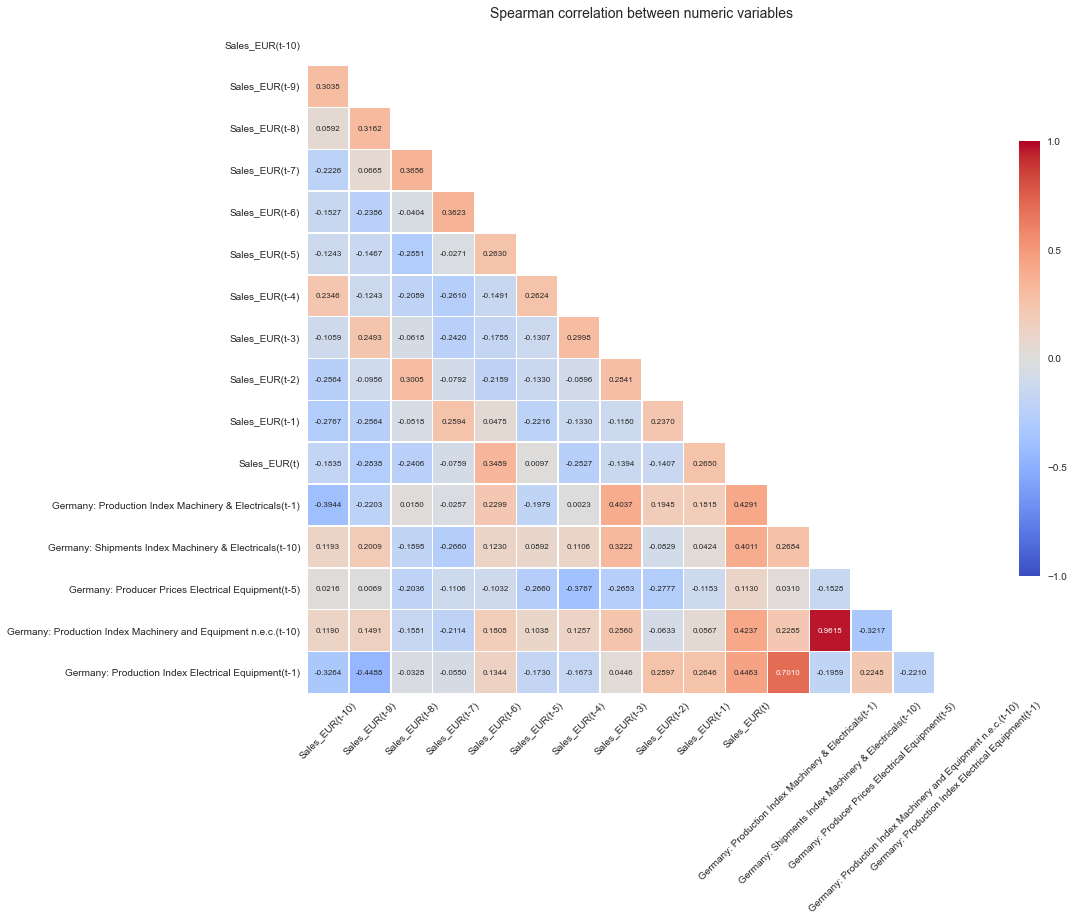

In [46]:
#Now we will create a correlation matrix

#Considering the amount of variables presented, most won't have a linear realitionship between each other, therefore we will use the Speraman's correlation
#We will still check the Pearson one further below
corr = X.corr(method='spearman')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

# Draw
fig , ax = plt.subplots(figsize=(15, 20))
heatmap = sns.heatmap(corr,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      fmt='.4f',
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': heatmaps_text_fontSize})

# Decoration
plt.title("Spearman correlation between numeric variables", fontsize=plots_Title_fontSize)
ax.set_yticklabels(corr.columns, rotation = 0)
ax.set_xticklabels(corr.columns, rotation = 45)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

## Modeling

In [47]:
# Create the Target
y = X['Sales_EUR(t)']

### WHAT SHOULD BE THE NUMBER OF MONTHS OF THE FORECAST?

In [48]:
# Split into train and test

#this is the number of forecasts, in this case I'm putting 1 year, replace the terms
days_forecast = 12

y_train = y[:-days_forecast]
y_test = y[-days_forecast:]

X_train = X[:-days_forecast]
X_test = X[-days_forecast:]

In [49]:
# Remove the Target from the training
X_train = X_train.drop(labels=['Sales_EUR(t)'],axis=1)
X_test = X_test.drop(labels=['Sales_EUR(t)'],axis=1)

In [50]:
# List maker function
def listmaker(value, n):
    listofv = [value] * n
    return listofv

# Create a temporary DF to scale data to predifined min and max
tempDF = pd.DataFrame(columns=X_train.columns)
values = listmaker(0, tempDF.shape[1]-1)  # set a row with 0 as minimum
values.append(0)
tempDF.loc[len(tempDF)] = values
values = listmaker(100, tempDF.shape[1]-1)  # set a row with 100 as maximum
values.append(1)
tempDF.loc[len(tempDF)] = values

# Normalize training data
scaler = MinMaxScaler(feature_range=(0, 1))
tempDF_scaled = scaler.fit_transform(tempDF)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [51]:
X_test

,Sales_EUR(t-10),Sales_EUR(t-9),Sales_EUR(t-8),Sales_EUR(t-7),Sales_EUR(t-6),Sales_EUR(t-5),Sales_EUR(t-4),Sales_EUR(t-3),Sales_EUR(t-2),Sales_EUR(t-1),Germany: Production Index Machinery & Electricals(t-1),Germany: Shipments Index Machinery & Electricals(t-10),Germany: Producer Prices Electrical Equipment(t-5),Germany: Production Index Machinery and Equipment n.e.c.(t-10),Germany: Production Index Electrical Equipment(t-1)
Date,,,,,,,,,,,,,,,
2021-05-01,35212730.13,37482085.58,38879360.20,41453854.50,37643611.57,34816959.18,27180432.94,34630522.81,33476138.64,41257397.90,108.016734,117.571172,110.908455,102.705811,105.509239
2021-06-01,37482085.58,38879360.20,41453854.50,37643611.57,34816959.18,27180432.94,34630522.81,33476138.64,41257397.90,37760015.28,102.878699,102.206355,111.434586,87.392059,100.661797
2021-07-01,38879360.20,41453854.50,37643611.57,34816959.18,27180432.94,34630522.81,33476138.64,41257397.90,37760015.28,35801398.47,115.558297,128.798156,111.645035,111.341393,112.522560
2021-08-01,41453854.50,37643611.57,34816959.18,27180432.94,34630522.81,33476138.64,41257397.90,37760015.28,35801398.47,37130004.21,110.680184,122.336895,111.750267,106.620613,107.778252
2021-09-01,37643611.57,34816959.18,27180432.94,34630522.81,33476138.64,41257397.90,37760015.28,35801398.47,37130004.21,36310817.42,100.880844,129.325685,111.960716,114.565346,103.446495
2021-10-01,34816959.18,27180432.94,34630522.81,33476138.64,41257397.90,37760015.28,35801398.47,37130004.21,36310817.42,36278886.58,115.043611,135.720643,112.171173,124.467476,111.697464
2021-11-01,27180432.94,34630522.81,33476138.64,41257397.90,37760015.28,35801398.47,37130004.21,36310817.42,36278886.58,44483013.86,108.420507,103.206701,112.381622,89.119171,106.231194
2021-12-01,34630522.81,33476138.64,41257397.90,37760015.28,35801398.47,37130004.21,36310817.42,36278886.58,44483013.86,34187395.60,115.951560,117.656513,113.223434,102.014969,110.047272
2022-01-01,33476138.64,41257397.90,37760015.28,35801398.47,37130004.21,36310817.42,36278886.58,44483013.86,34187395.60,33950069.83,118.103281,147.238328,113.960014,125.618881,97.773956


In [52]:
model = MLPRegressor(random_state=21, hidden_layer_sizes=6, max_iter=400)

## There is no cross validation?!!?

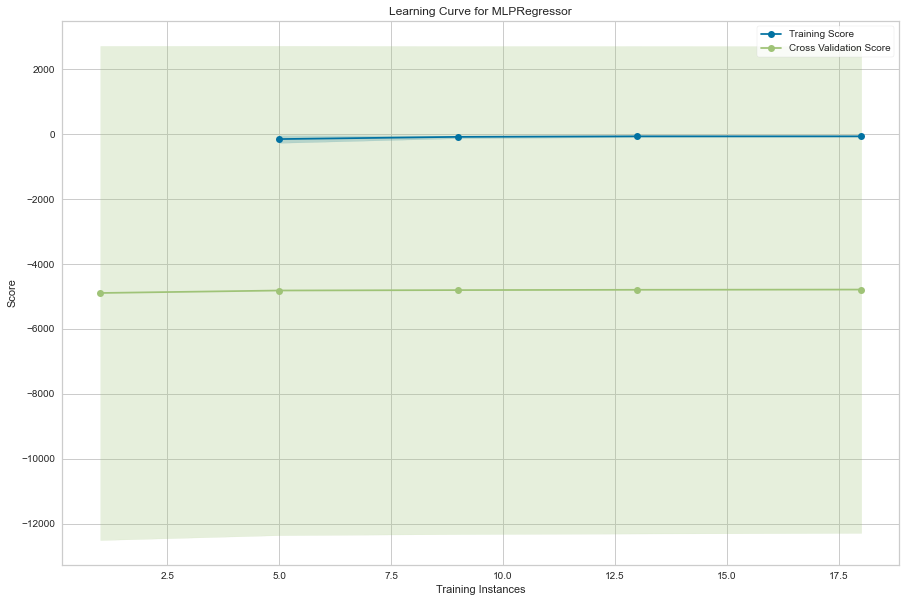

<AxesSubplot:title={'center':'Learning Curve for MLPRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [53]:
# Plot the learning curve
cv = 10
sizes = np.linspace(0.1, 1.0, 5)
visualizer = LearningCurve(estimator=model, cv=cv, scoring='r2', train_sizes=sizes, n_jobs=4, random_state=123)
visualizer.fit(X_train_scaled, y_train)
visualizer.show()

In [54]:
# Create and train the model
model.fit(X_train_scaled, y_train)

MLPRegressor(hidden_layer_sizes=6, max_iter=400, random_state=21)

## Evaluation

In [55]:
# predict y for X_train and X_test
y_pred_train = model.predict(X_train_scaled) 
y_pred_test = model.predict(X_test_scaled) 

In [56]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest,set1='Train', set2='Test'):
  measures_list = ['MAE','RMSE', 'R^2','MAPE (%)','MAX Error']
  train_results = [metricsObj.mean_absolute_error(yTrain, yPredTrain),
                np.sqrt(metricsObj.mean_squared_error(yTrain, yPredTrain)),
                metricsObj.r2_score(yTrain, yPredTrain),
                metricsObj.mean_absolute_percentage_error(yTrain, yPredTrain),
                metricsObj.max_error(yTrain, yPredTrain)]
  test_results = [metricsObj.mean_absolute_error(yTest, yPredTest),
                np.sqrt(metricsObj.mean_squared_error(yTest, yPredTest)),
                metricsObj.r2_score(yTest, yPredTest),
                  metricsObj.mean_absolute_percentage_error(yTest, yPredTest),
                metricsObj.max_error(yTest, yPredTest)]
  resultsDF = pd.DataFrame({'Measure': measures_list, set1: train_results, set2:test_results})
  return(resultsDF)

In [57]:
# Show performance results
resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_test)
resultsDF

,Measure,Train,Test
0,MAE,2.914636e+07,3.047093e+07
1,RMSE,2.937336e+07,3.060967e+07
2,R^2,-6.700000e+01,-1.116081e+02
3,MAPE (%),8.012871e-01,8.089183e-01
4,MAX Error,3.453634e+07,3.748182e+07


In [58]:
# Visualize predictions vs close values 
temp = y_test.to_frame()
temp['Prediction'] = y_pred_test
temp['Residual'] = y_test - temp.Prediction
temp

,Sales_EUR(t),Prediction,Residual
Date,,,
2021-05-01,37760015.28,7.027966e+06,3.073205e+07
2021-06-01,35801398.47,7.069948e+06,2.873145e+07
2021-07-01,37130004.21,7.100821e+06,3.002918e+07
2021-08-01,36310817.42,6.969417e+06,2.934140e+07
2021-09-01,36278886.58,6.941188e+06,2.933770e+07
2021-10-01,44483013.86,7.001192e+06,3.748182e+07
2021-11-01,34187395.60,7.215980e+06,2.697142e+07
2021-12-01,33950069.83,7.362792e+06,2.658728e+07
2022-01-01,37942942.06,7.359171e+06,3.058377e+07


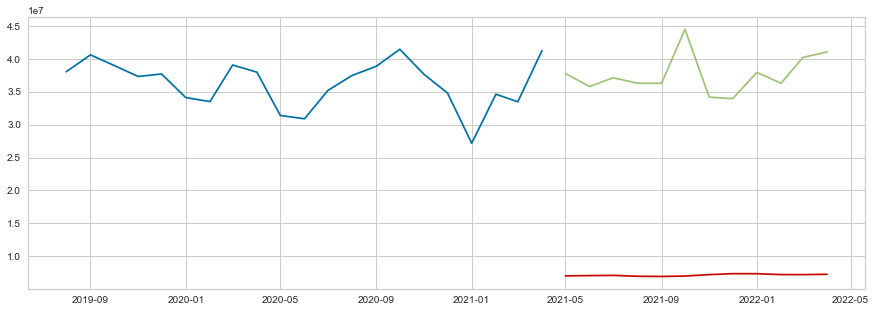

In [59]:
# Plot close price time series
plt.figure(figsize=(15,5))
plt.plot(X[:-days_forecast]['Sales_EUR(t)'])
plt.plot(temp[['Sales_EUR(t)', 'Prediction']])

#### With walk-forward approach

In [60]:
# Create first element based on first row of X_test
X_valid = X_test[:1]
y_valid = pd.Series([],dtype=np.float)
n = 0
for date in pd.to_datetime(X_test.index.values):
    # Get current day values
    currentDay = X_valid[X_valid.index==date]
    currentDay_scaled = scaler.transform(currentDay.values) # scaled using the same scaler, not fiting a new one

    # Predict an y for each date and add it to results series
    y_valid[n] = model.predict(currentDay_scaled)[0]
    n = n + 1

    # Add a new row to X_valid
    if n < days_forecast:
        X_valid = X_valid.append(X_test.iloc[n])
        newDate = X_valid.index[-1]

        # Shift values 1 day
        copyToCol = ['Sales_EUR(t-'+str(j)+')' for j in range(lagDays,2, -1)]
        copyFromCol = ['Sales_EUR(t-'+str(j)+')' for j in range(lagDays-1,1, -1)]
        shiftValues = X_valid[X_valid.index==date][copyFromCol].values.tolist()
        X_valid.loc[X_valid.index==newDate, copyToCol] = shiftValues
    
        # Set last day with the value predicted
        X_valid.loc[X_valid.index==newDate,'Sales_EUR(t-1)'] = y_valid[n-1]

In [61]:
# Show performance results
resultsDF = performanceMetricsDF(metrics, y_test, y_pred_test, y_test, y_valid, 'Test', 'Valid')
resultsDF

,Measure,Test,Valid
0,MAE,3.047093e+07,3.087047e+07
1,RMSE,3.060967e+07,3.100691e+07
2,R^2,-1.116081e+02,-1.145498e+02
3,MAPE (%),8.089183e-01,8.196189e-01
4,MAX Error,3.748182e+07,3.790628e+07


In [62]:
# Visualize predictions vs close values 
temp = y_test.to_frame()
temp['Prediction_WalkForward'] = y_valid.values
temp['Residual'] = temp['Sales_EUR(t)'] - y_valid.values
temp

,Sales_EUR(t),Prediction_WalkForward,Residual
Date,,,
2021-05-01,37760015.28,7.027966e+06,3.073205e+07
2021-06-01,35801398.47,6.631659e+06,2.916974e+07
2021-07-01,37130004.21,6.684813e+06,3.044519e+07
2021-08-01,36310817.42,6.535219e+06,2.977560e+07
2021-09-01,36278886.58,6.516539e+06,2.976235e+07
2021-10-01,44483013.86,6.576732e+06,3.790628e+07
2021-11-01,34187395.60,6.675374e+06,2.751202e+07
2021-12-01,33950069.83,6.970425e+06,2.697964e+07
2022-01-01,37942942.06,6.974397e+06,3.096855e+07


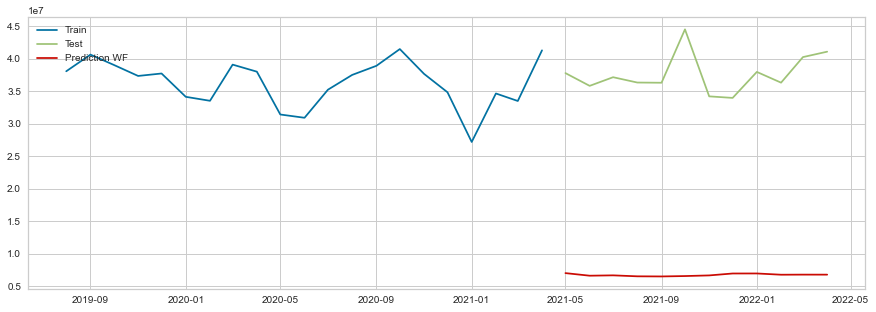

In [63]:
# Plot forecast
plt.figure(figsize=(15,5))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(temp['Prediction_WalkForward'], label='Prediction WF')
plt.legend(loc='upper left')
plt.show()